# Chapter 3. EDA w/ DuckDB

[- https://learning.oreilly.com/library/view/duckdb-up-and/9781098159689/ch02.html](https://learning.oreilly.com/library/view/duckdb-up-and/9781098159689/ch03.html#our_dataset_the_2015_flights_delay_dataset)

## LOAD DATA

In [1]:
import duckdb

conn = duckdb.connect()  # in memory

In [2]:
# load fligts data
conn.execute(
    """
CREATE TABLE flights
AS
SELECT *
FROM read_csv_auto('../data/flights.csv')
"""
)

In [3]:
# load airports data
conn.execute(
    """
CREATE TABLE airports
AS
SELECT *
FROM read_csv_auto('../data/airports.csv')
"""
)

In [4]:
conn.execute(
    """
    CREATE TABLE airlines
    as
    SELECT
        *
    FROM read_csv('../data/airlines.csv',
                  Header = True,
                  Columns = {
                    'IATA_CODE': 'VARCHAR',
                    'AIRLINE': 'VARCHAR'
                  })
"""
)

In [5]:
# show tables
conn.execute("SHOW TABLES;").df()

,name
0,airlines
1,airports
2,flights


## EDA - GEO SPATIAL DATA

In [6]:
import folium

In [7]:
# show US map
mymap = folium.Map(
    location=[47.116386, -101.2999591],
    width=950,
    height=550,
    zoom_start=3,
    tiles="openstreetmap",
)

mymap

In [8]:
import folium

mymap = folium.Map(
    location=[47.116386, -101.299591],
    width=950,
    height=550,
    zoom_start=3,
    tiles="openstreetmap",
)

folium.TileLayer("cartodbpositron", attr="cartodbpositron").add_to(mymap)
folium.TileLayer("cartodbdark_matter", attr="cartodbdark_matter").add_to(mymap)
folium.LayerControl().add_to(mymap)

mymap

### Display all airports on the map

In [9]:
df = conn.execute(
    """
SELECT *
FROM airports
"""
).df()

df.shape

(322, 7)

In [10]:
df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [11]:
import math

for lat, lng, airport in zip(df["LATITUDE"], df["LONGITUDE"], df["AIRPORT"]):
    if math.isnan(lat) or math.isnan(lng):
        continue

    airport = folium.CircleMarker(
        location=[lat, lng],
        radius=4,
        color="red",
        fill=True,
        fill_color="yellow",
        fill_opacity=0.5,
        popup=airport,
    )

    airport.add_to(mymap)

mymap

In [12]:
import math

df = conn.execute(
    """
    SELECT
    *
    FROM airports
"""
).df()

for lat, lng, airport in zip(df["LATITUDE"], df["LONGITUDE"], df["AIRPORT"]):
    if math.isnan(lat) or math.isnan(lng):
        continue

    airport = folium.Marker(
        location=[lat, lng],
        popup=airport,
        icon=folium.Icon(
            color="lightgray",  # icon to display in
            icon="plane-arrival",  # the marker
            prefix="fa",
        ),
    )
    airport.add_to(mymap)

mymap

### DuckDB spatial Extension

In [13]:
import pandas as pd

df = pd.read_csv("../data/airports.csv")
df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [14]:
from shapely.geometry import Point

df["geometry"] = df.apply(
    lambda row: Point(row["LONGITUDE"], row["LATITUDE"]).wkt, axis=1
)

df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,geometry
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,POINT (-75.4404 40.65236)
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,POINT (-99.6819 32.41132)
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,POINT (-106.60919 35.04022)
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,POINT (-98.42183 45.44906)
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,POINT (-84.19447 31.53552)


In [15]:
conn.register("airports_2", df)

In [16]:
conn.install_extension("spatial")

In [17]:
conn.load_extension("spatial")

In [18]:
import leafmap

df_airports_gdf = leafmap.df_to_gdf(
    df, geometry="geometry", src_crs="EPSG:4326", dst_crs="EPSG:4326"
)

In [19]:
df_airports_gdf.explore()

In [20]:
# get co-ordinates of louisville
df.query("CITY=='Louisville'")

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,geometry
276,SDF,Louisville International Airport (Standiford F...,Louisville,KY,USA,38.17439,-85.736,POINT (-85.736 38.17439)


In [21]:
LOUISVILLE_LNGLAT = (-85.736, 38.17439)

# within 3 degrees
df_airports_near_louisville = conn.sql(
    f"""
    SELECT *
    FROM airports_2
    WHERE ST_DWithin(
        ST_GeomFromText(geometry),
        ST_GeomFromText('POINT ({LOUISVILLE_LNGLAT[0]} {LOUISVILLE_LNGLAT[1]})'),
        3);
"""
).df()

In [22]:
df_airports_near_louisville.sort_values(by="LATITUDE")

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,geometry
8,TYS,McGhee Tyson Airport,Knoxville,TN,USA,35.81249,-83.99286,POINT (-83.99286 35.81249)
0,BNA,Nashville International Airport,Nashville,TN,USA,36.12448,-86.67818,POINT (-86.67818 36.12448)
6,LEX,Blue Grass Airport,Lexington,KY,USA,38.03697,-84.60539,POINT (-84.60539 38.03697)
3,EVV,Evansville Regional Airport,Evansville,IN,USA,38.03799,-87.53063,POINT (-87.53063 38.03799)
7,SDF,Louisville International Airport (Standiford F...,Louisville,KY,USA,38.17439,-85.73600,POINT (-85.736 38.17439)
1,CVG,Cincinnati/Northern Kentucky International Air...,Covington,KY,USA,39.04614,-84.66217,POINT (-84.66217 39.04614)
5,IND,Indianapolis International Airport,Indianapolis,IN,USA,39.71733,-86.29438,POINT (-86.29438 39.71733)
2,DAY,James M. Cox Dayton International Airport,Dayton,OH,USA,39.90238,-84.21938,POINT (-84.21938 39.90238)
4,FWA,Fort Wayne International Airport,Fort Wayne,IN,USA,40.97847,-85.19515,POINT (-85.19515 40.97847)


In [23]:
# plot the airports
import leafmap

df_airports_near_louisville_gdf = leafmap.df_to_gdf(
    df_airports_near_louisville, src_crs="EPSG:4326", dst_crs="EPSG:4326"
)

folium_map = df_airports_near_louisville_gdf.explore()
folium_map

In [24]:
import folium

folium.Marker(
    location=[LOUISVILLE_LNGLAT[1], LOUISVILLE_LNGLAT[0]], popup="Louisville"
).add_to(folium_map)

folium_map

## PERFORMING DESCRIPTIVE ANLYTICS

In [30]:
df_city_state = conn.execute(
    """
SELECT *
FROM airports
ORDER BY STATE, CITY;
"""
).df()

df_city_state

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ADK,Adak Airport,Adak,AK,USA,51.87796,-176.64603
1,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
2,BRW,Wiley Post-Will Rogers Memorial Airport,Barrow,AK,USA,71.28545,-156.76600
3,BET,Bethel Airport,Bethel,AK,USA,60.77978,-161.83800
4,CDV,Merle K. (Mudhole) Smith Airport,Cordova,AK,USA,60.49183,-145.47765
...,...,...,...,...,...,...,...
317,COD,Yellowstone Regional Airport,Cody,WY,USA,44.52019,-109.02380
318,GCC,Gillette-Campbell County Airport,Gillette,WY,USA,44.34890,-105.53936
319,JAC,Jackson Hole Airport,Jackson,WY,USA,43.60732,-110.73774
320,LAR,Laramie Regional Airport,Laramie,WY,USA,41.31205,-105.67499


In [ ]:
df_city_state.set_index(["STATE", "CITY"], inplace=True)

In [33]:
df_city_state

IATA_CODE                                      AIRPORT  \
STATE CITY                                                                  
AK    Adak               ADK                                 Adak Airport   
      Anchorage          ANC  Ted Stevens Anchorage International Airport   
      Barrow             BRW      Wiley Post-Will Rogers Memorial Airport   
      Bethel             BET                               Bethel Airport   
      Cordova            CDV             Merle K. (Mudhole) Smith Airport   
...                      ...                                          ...   
WY    Cody               COD                 Yellowstone Regional Airport   
      Gillette           GCC             Gillette-Campbell County Airport   
      Jackson            JAC                         Jackson Hole Airport   
      Laramie            LAR                     Laramie Regional Airport   
      Rock Springs       RKS       Rock Springs-Sweetwater County Airport   

                   COUNTRY  LATITUDE  LONGITUDE  
STATE CITY                                       
AK    Adak             USA  51.87796 -176.64603  
      Anchorage        USA  61.17432 -149.99619  
      Barrow           USA  71.28545 -156.76600  
      Bethel           USA  60.77978 -161.83800  
      Cordova          USA  60.49183 -145.47765  
...                    ...       ...        ...  
WY    Cody             USA  44.52019 -109.02380  
      Gillette         USA  44.34890 -105.53936  
      Jackson          USA  43.60732 -110.73774  
      Laramie          USA  41.31205 -105.67499  
      Rock Springs     USA  41.59422 -109.06519  

[322 rows x 5 columns]

In [36]:
df_city_state.loc["CA"]

,IATA_CODE,AIRPORT,COUNTRY,LATITUDE,LONGITUDE
CITY,,,,,
Arcata/Eureka,ACV,Arcata Airport,USA,40.97812,-124.10862
Bakersfield,BFL,Meadows Field,USA,35.43360,-119.05677
Burbank,BUR,Bob Hope Airport (Hollywood Burbank Airport),USA,34.20062,-118.35850
Crescent City,CEC,Del Norte County Airport (Jack McNamara Field),USA,41.78016,-124.23653
Fresno,FAT,Fresno Yosemite International Airport,USA,36.77619,-119.71814
Long Beach,LGB,Long Beach Airport (Daugherty Field),USA,33.81772,-118.15161
Los Angeles,LAX,Los Angeles International Airport,USA,33.94254,-118.40807
Mammoth Lakes,MMH,Mammoth Yosemite Airport,USA,37.62405,-118.83777
Monterey,MRY,Monterey Regional Airport (Monterey Peninsula ...,USA,36.58698,-121.84295


In [37]:
df_city_state.loc[("CA", "San Francisco")]

,,IATA_CODE,AIRPORT,COUNTRY,LATITUDE,LONGITUDE
STATE,CITY,,,,,
CA,San Francisco,SFO,San Francisco International Airport,USA,37.619,-122.37484


In [46]:
df_airports_state = conn.execute(
    """
select STATE,
count(*) as COUNT
from airports
group by state
order by COUNT DESC
LIMIT 10
"""
).df()

df_airports_state.head()

,STATE,COUNT
0,TX,24
1,CA,22
2,AK,19
3,FL,17
4,MI,15


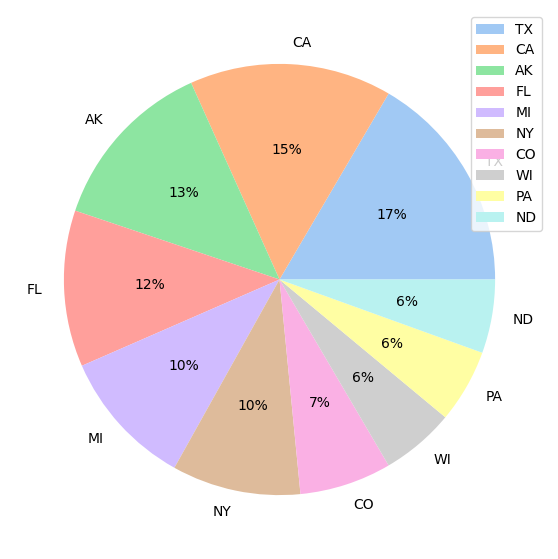

In [47]:
import matplotlib.pyplot as plt
import seaborn

palette_color = seaborn.color_palette("pastel")
plt.figure(figsize=(7, 7))
plt.pie(
    df_airports_state["COUNT"],
    labels=df_airports_state["STATE"],
    colors=palette_color,
    autopct="%.0f%%",
)

plt.legend(df_airports_state["STATE"], loc="best")

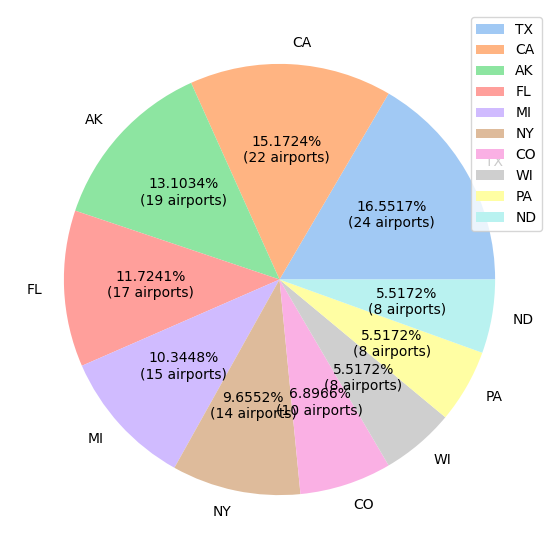

In [48]:
# total number of airports
total = df_airports_state["COUNT"].sum()


def fmt(x):
    return "{:.4f}%\n({:.0f} airports)".format(x, total * x / 100)


palette_color = seaborn.color_palette("pastel")
plt.figure(figsize=(7, 7))

plt.pie(
    df_airports_state["COUNT"],
    labels=df_airports_state["STATE"],
    colors=palette_color,
    autopct=fmt,
)

plt.legend(df_airports_state["STATE"], loc="best")

### Finding the most common Timeslot for Flight Delays

In [ ]:
df_delays_by_week = conn.execute('''
select
DAY_OF_WEEK,
CASE
    WHEN
''')